In [20]:
#"Hayvan Tanıma Git Repostory Oluşturuldu"

In [21]:
import os

import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, History
import tensorflow as tf
from time import time
import numpy as np
import pandas as pd
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # UYARILARI KAPATMA


In [22]:
#print(os.listdir("./images/train"))
SIZE = 224
EPOCH = 50
BATCH = 32
train_directory = "images/train/"
valid_directory = "images/valid/"
test_directory = "images/test/"

data_aug = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)
#Max batch size= available GPU memory bytes / 4 / (size of tensors + trainable parameters)
train_generator = data_aug.flow_from_directory(directory=train_directory,
                                               batch_size=BATCH,
                                               shuffle=True,
                                               class_mode="categorical",
                                               color_mode="rgb",
                                               target_size=(SIZE, SIZE),
                                               interpolation="nearest",
                                               seed=42
                                               )
validation_generator = data_aug.flow_from_directory(directory=valid_directory,
                                                    batch_size=BATCH,
                                                    shuffle=True,
                                                    class_mode="categorical",
                                                    color_mode="rgb",
                                                    target_size=(SIZE, SIZE),
                                                    interpolation="nearest",
                                                    seed=42
                                                    )
test_generator = data_aug.flow_from_directory(directory=test_directory,
                                              batch_size=1,
                                              shuffle=False,
                                              class_mode="categorical",
                                              color_mode="rgb",
                                              target_size=(SIZE, SIZE),
                                              seed=42
                                              )




Found 5836 images belonging to 37 classes.
Found 777 images belonging to 37 classes.
Found 777 images belonging to 37 classes.


In [23]:
print(train_generator.class_indices)

{'Abyssinian': 0, 'Bengal': 1, 'Birman': 2, 'Bombay': 3, 'British_Shorthair': 4, 'Egyptian_Mau': 5, 'Maine_Coon': 6, 'Persian': 7, 'Ragdoll': 8, 'Russian_Blue': 9, 'Siamese': 10, 'Sphynx': 11, 'american_bulldog': 12, 'american_pit_bull_terrier': 13, 'basset_hound': 14, 'beagle': 15, 'boxer': 16, 'chihuahua': 17, 'english_cocker_spaniel': 18, 'english_setter': 19, 'german_shorthaired': 20, 'great_pyrenees': 21, 'havanese': 22, 'japanese_chin': 23, 'keeshond': 24, 'leonberger': 25, 'miniature_pinscher': 26, 'newfoundland': 27, 'pomeranian': 28, 'pug': 29, 'saint_bernard': 30, 'samoyed': 31, 'scottish_terrier': 32, 'shiba_inu': 33, 'staffordshire_bull_terrier': 34, 'wheaten_terrier': 35, 'yorkshire_terrier': 36}


In [24]:
tf.keras.backend.clear_session()

In [25]:
vgg16_model = VGG16(pooling="avg", input_shape=(224, 224, 3), weights="imagenet", include_top=False)
for layers in vgg16_model.layers:
    layers.trainable=False

output = vgg16_model.layers[-1].output
vgg = Flatten()(output)
vgg = Dense(units=500, activation="relu")(vgg)
vgg = Dense(units=37, activation="softmax")(vgg)
vgg_final = Model(vgg16_model.input, vgg)
vgg_final.compile(loss="categorical_crossentropy", optimizer="adam",
                  metrics=["acc"])



In [26]:
vgg16_filepath = 'vgg_16_' + '-saved-model-{epoch:02d}-acc-{val_acc:.2f}.hdf5'
vgg16_checkpoint = ModelCheckpoint(filepath=vgg16_filepath,
                                   save_best_only=True,
                                   monitor="val_acc",
                                   mode="max",
                                   verbose=1
                                   )
vgg16_early_stopping = EarlyStopping(monitor="val_loss",
                                     restore_best_weights=True,
                                     patience=5,
                                     verbose=1,
                                     )
vgg16_tensorboard = TensorBoard(log_dir="logs/{}".format(time()),
                                write_graph=True,
                                write_images=True,
                                histogram_freq=0)
vgg16_history_callback = History()

Step_size_train = train_generator.n // train_generator.batch_size
Step_size_valid = validation_generator.n // validation_generator.batch_size
Step_size_test =  test_generator.n // test_generator.batch_size

print(Step_size_train, Step_size_valid)
vgg_history = vgg_final.fit_generator(
    generator=train_generator,
    validation_data=validation_generator,
    epochs=EPOCH,
    callbacks=[vgg16_history_callback, vgg16_checkpoint, vgg16_early_stopping, vgg16_tensorboard],
    steps_per_epoch=Step_size_train,
    validation_steps=Step_size_valid
)


182 24
Epoch 1/50
  2/182 [..............................] - ETA: 2:44 - loss: 3.6972 - acc: 0.0625

2022-05-01 11:18:25.063954: E tensorflow/core/platform/default/device_tracer.cc:68] CUPTI error: CUPTI_ERROR_INVALID_PARAMETER


181/182 [============================>.] - ETA: 0s - loss: 3.3360 - acc: 0.1085
Epoch 00001: val_acc improved from -inf to 0.18229, saving model to vgg_16_-saved-model-01-acc-0.18.hdf5
182/182 [==============================] - 128s 702ms/step - loss: 3.3329 - acc: 0.1092 - val_loss: 2.9624 - val_acc: 0.1823
Epoch 2/50
181/182 [============================>.] - ETA: 0s - loss: 2.6859 - acc: 0.2595
Epoch 00002: val_acc improved from 0.18229 to 0.26172, saving model to vgg_16_-saved-model-02-acc-0.26.hdf5
182/182 [==============================] - 123s 674ms/step - loss: 2.6873 - acc: 0.2595 - val_loss: 2.5500 - val_acc: 0.2617
Epoch 3/50
181/182 [============================>.] - ETA: 0s - loss: 2.3265 - acc: 0.3365
Epoch 00003: val_acc improved from 0.26172 to 0.36589, saving model to vgg_16_-saved-model-03-acc-0.37.hdf5
182/182 [==============================] - 123s 674ms/step - loss: 2.3258 - acc: 0.3368 - val_loss: 2.2668 - val_acc: 0.3659
Epoch 4/50
181/182 [======================

KeyError: 'accuracy'

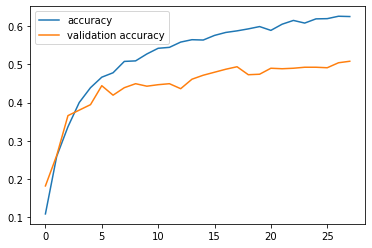

In [27]:
plt.plot(vgg16_history_callback.history["acc"])
plt.plot(vgg16_history_callback.history['val_acc'])
plt.legend(['accuracy','validation accuracy'])

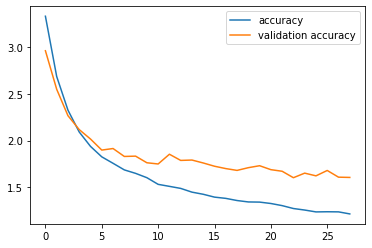

In [28]:
plt.plot(vgg16_history_callback.history["loss"])
plt.plot(vgg16_history_callback.history['val_loss'])
plt.legend(['accuracy','validation accuracy'])

In [29]:
vgg_final.evaluate_generator(generator=validation_generator,
                             steps=Step_size_valid)
test_generator.reset()

pred = vgg_final.predict_generator(generator=test_generator,
                                   steps=Step_size_test,
                                   verbose=1)
predicted_class_indces =np.argmax(pred,axis=1)

777/777 [==============================] - 32s 41ms/step


In [30]:
labels = train_generator.class_indices
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indces]

In [31]:
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv("results.csv",index=False)

In [33]:
results

,Filename,Predictions
0,Abyssinian/Abyssinian_1.jpg,Abyssinian
1,Abyssinian/Abyssinian_10.jpg,chihuahua
2,Abyssinian/Abyssinian_11.jpg,Abyssinian
3,Abyssinian/Abyssinian_12.jpg,Russian_Blue
4,Abyssinian/Abyssinian_13.jpg,Abyssinian
...,...,...
772,yorkshire_terrier/yorkshire_terrier_4.jpg,yorkshire_terrier
773,yorkshire_terrier/yorkshire_terrier_5.jpg,havanese
774,yorkshire_terrier/yorkshire_terrier_6.jpg,scottish_terrier
775,yorkshire_terrier/yorkshire_terrier_7.jpg,pomeranian
